### Test Dataset에 돌렸을 때, -1이 얼마나 있는지 확인

In [1]:
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from PIL import Image

In [15]:
# BEiT version1 학습된 모델에 대해서 평가 - public LB 0.7728
# DeeplabV3+ version1 학습된 모델에 대해서 평가 - public LB 0.7652

test_result_beit = pd.read_csv("/home/mykang/mmsegmentation/_satellite/deeplabv3plus_ver1/example_next_1600.csv")
test_result_deeplab = pd.read_csv("/home/mykang/mmsegmentation/_satellite/upernet_beit_ver1/result.csv")

test_number = test_result_beit.shape[0]
test_number

60640

In [16]:
beit_count = len(test_result_beit[test_result_beit['mask_rle'] == '-1'])
deeplab_count = len(test_result_deeplab[test_result_deeplab['mask_rle'] == '-1'])

print("beit : ", beit_count, "ratio : ", beit_count / test_number)
print("deeplab : ", deeplab_count, "ratio : ", deeplab_count / test_number)

beit :  16946 ratio :  0.27945250659630605
deeplab :  15756 ratio :  0.25982849604221636


### Test Dataset에 돌렸을 때, 각 이미지별로 정답 pixel이 몇개 있는지 조사

In [17]:
# BEiT_ver1 결과에 대해서 분석
test_inference_list = glob("/home/mykang/mmsegmentation/_inference/20230704_beit_upernet/*.png")

pixel_num_list = []

for predict_path in tqdm(test_inference_list):

    mask = cv2.imread(predict_path, cv2.IMREAD_GRAYSCALE)
    pixel_num_list.append(mask.sum())

100%|██████████| 60640/60640 [01:17<00:00, 779.09it/s] 


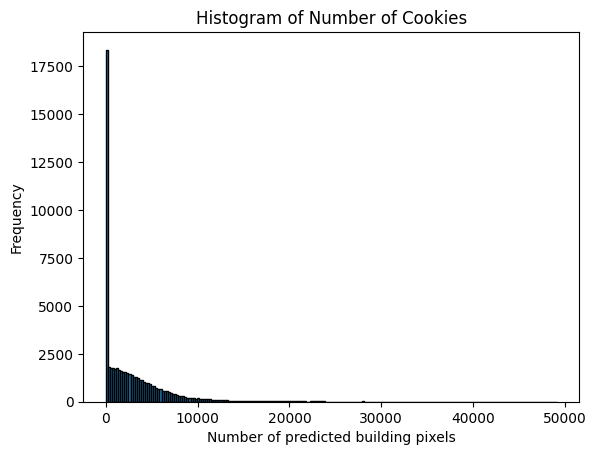

In [18]:
plt.hist(pixel_num_list, bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('Number of predicted building pixels')
plt.ylabel('Frequency')
plt.title('Histogram of Number of pixels')

# Display the histogram
plt.show()

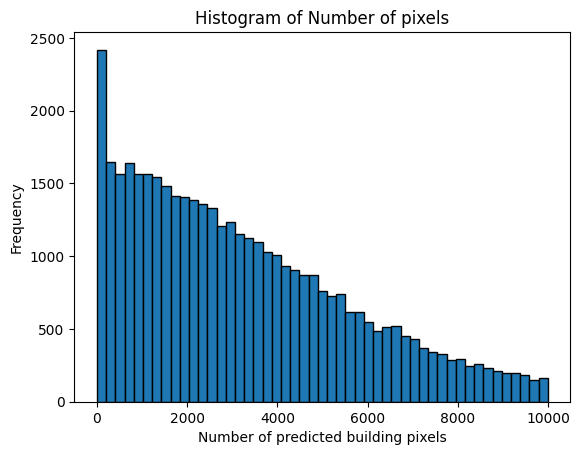

In [33]:
# under 10000
pixel_num_list_under10000 = [num for num in pixel_num_list if 0 < num and num < 10000]

plt.hist(pixel_num_list_under10000, bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('Number of predicted building pixels')
plt.ylabel('Frequency')
plt.title('Histogram of Number of pixels')

# Display the histogram
plt.show()

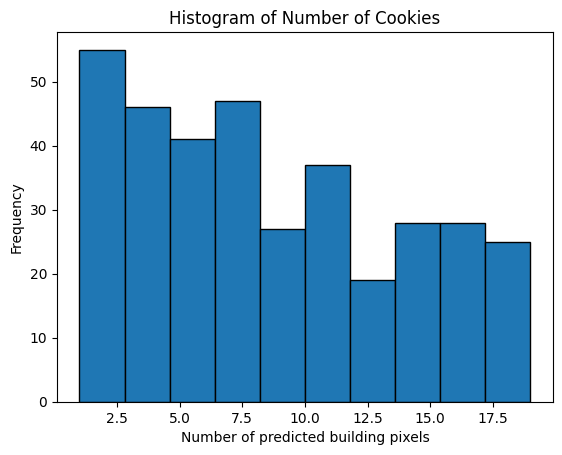

In [22]:
# pixel의 개수가 100보다 작은 경우에 한해서 생각해보자 -> #TODO: pixel개수가 5보다 작은 경우에는 아예 -1로 제외해도 되지 않을까?
pixel_num_list_under100 = [num for num in pixel_num_list if num < 20 and num > 0]

# Assuming your list is called 'cookie_counts'
plt.hist(pixel_num_list_under100, bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('Number of predicted building pixels')
plt.ylabel('Frequency')
plt.title('Histogram of Number of pixels')

# Display the histogram
plt.show()

### 사용하고 있는 Validation에서 이미지당 gt pixel 개수의 분포는?

In [2]:
# validation data에 대해서 생각 (size = 256 * 256)
val_gt_list = glob("/home/mykang/mmsegmentation/data/Satellite/ann_dir/val_slice/*.png")

val_pixel_num_list = []

for predict_path in tqdm(val_gt_list):

    mask = cv2.imread(predict_path, cv2.IMREAD_GRAYSCALE)
    val_pixel_num_list.append(mask.sum())

100%|██████████| 17136/17136 [00:21<00:00, 785.38it/s] 


In [24]:
# pixel 개수가 0인 이미지의 개수와 비율
val_pixel_zero_list = [num for num in val_pixel_num_list if num == 0]
print("zero gt pixel : ", len(val_pixel_zero_list), "ratio : ", len(val_pixel_zero_list) / len(val_pixel_num_list))

zero gt pixel :  3933 ratio :  0.22951680672268907


In [5]:
# pixel 개수가 1개 혹은 2개인 이미지의 개수와 비율
val_pixel_leq2_list = [num for num in val_pixel_num_list if 0 < num <= 2]
print("zero gt pixel : ", len(val_pixel_leq2_list), "ratio : ", len(val_pixel_leq2_list) / len(val_pixel_num_list))

zero gt pixel :  15 ratio :  0.0008753501400560224


얼추비슷하게 나옴 비율이 (28% 25% <-> 22%)
- 다만, 정답이 아예 없는 경우는 생각보다 잘 예측하고 이 부분은 dice 계산에 사용되지 않음
- 그러니까 validation set의 비율을 정답이 있는 경우로 늘리는건 어떨까?

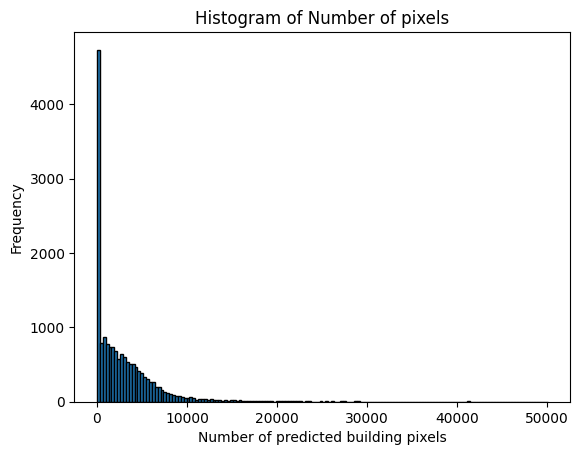

In [29]:
# histogram 비교를 위해서 이미지를 resize해서 생각하겠음
val_pixel_num_list_resize = [num * (224 * 224) / (256 * 256)  for num in val_pixel_num_list]
plt.hist(val_pixel_num_list_resize, bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('Number of predicted building pixels')
plt.ylabel('Frequency')
plt.title('Histogram of Number of pixels')

# Display the histogram
plt.show()

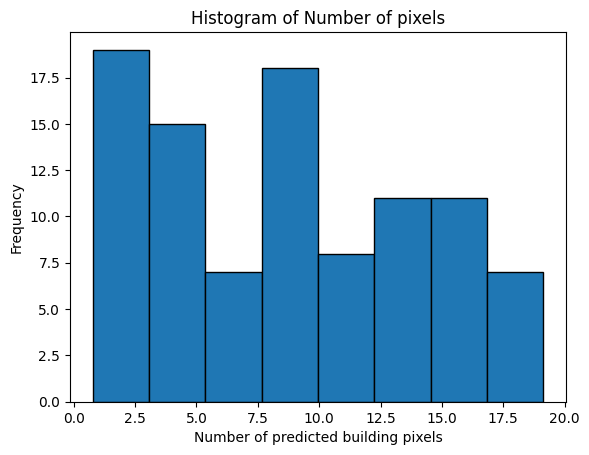

In [41]:
# under 10000
pixel_num_list_under20 = [num for num in val_pixel_num_list_resize if num > 0 and num < 20]

plt.hist(pixel_num_list_under20, bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('Number of predicted building pixels')
plt.ylabel('Frequency')
plt.title('Histogram of Number of pixels')

# 정답 개수가 1인걸 한번 볼게 2,3,4 있는지..
# human clustering -> 나쁘지 않아
# 
# (-1)을 구분하는 것이 어떨까? (binary classification) -> 난이도가 낮을테니까 -> training 시킬 수 있는 환경은 구축됨 -> threshold를 기준으로
# 앙상블 형식으로 (binary classification에게 가중치를 줘서)

# Display the histogram
plt.show()

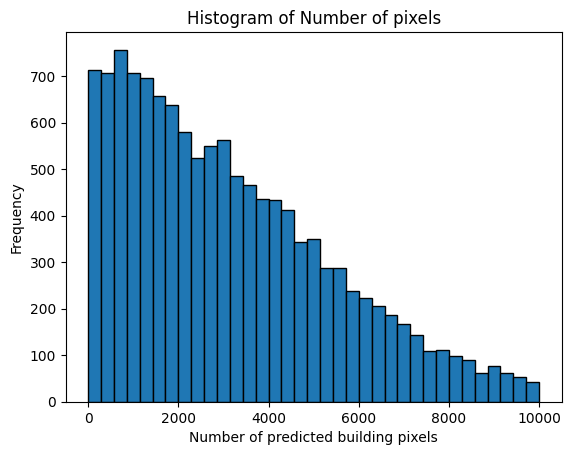

In [32]:
# under 10000
pixel_num_list_under10000 = [num for num in val_pixel_num_list_resize if num > 0 and num < 10000]

plt.hist(pixel_num_list_under10000, bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('Number of predicted building pixels')
plt.ylabel('Frequency')
plt.title('Histogram of Number of pixels')

# Display the histogram
plt.show()

### RGB mean & std 분석
- 현재 쓰고 있는 pretrained model의 mean, std
    - mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375],

- train dataset의 mean, std
    - mean=[87.3359904, 91.29594915, 83.01340125], std=[43.7584692, 38.600545950000004, 35.4384822]

In [36]:
def get_img_stats(image_paths):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        image_paths: 학습 데이터셋 이미지 경로 

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for image_path in tqdm(image_paths):
        img = np.array(Image.open(image_path))
        h, w, _ = img.shape
        img_info['heights'].append(h)
        img_info['widths'].append(w)
        img_info['means'].append(img.mean(axis=(0,1)))
        img_info['stds'].append(img.std(axis=(0,1)))
        
    return img_info

In [39]:

# train data

train_img_paths = glob("/home/mykang/mmsegmentation/data/Satellite/img_dir/train/*.png")

img_info = get_img_stats(train_img_paths)

print(f'Total number of imgage is {len(train_img_paths)}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {np.mean(img_info["heights"])}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {np.mean(img_info["widths"])}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

  0%|          | 0/6069 [00:00<?, ?it/s]

100%|██████████| 6069/6069 [19:30<00:00,  5.19it/s]

Total number of imgage is 6069
Minimum height for dataset is 1024
Maximum height for dataset is 1024
Average height for dataset is 1024.0
Minimum width for dataset is 1024
Maximum width for dataset is 1024
Average width for dataset is 1024.0
RGB Mean: [0.34249408 0.35802333 0.32554275]
RGB Standard Deviation: [0.17160184 0.15137469 0.13897444]


In [40]:
# test data

test_img_paths = glob("/home/mykang/mmsegmentation/data/Satellite/img_dir/test/*.png")

img_info = get_img_stats(test_img_paths)

print(f'Total number of imgage is {len(test_img_paths)}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {np.mean(img_info["heights"])}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {np.mean(img_info["widths"])}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

100%|██████████| 60640/60640 [13:06<00:00, 77.11it/s]  


Total number of imgage is 60640
Minimum height for dataset is 224
Maximum height for dataset is 224
Average height for dataset is 224.0
Minimum width for dataset is 224
Maximum width for dataset is 224
Average width for dataset is 224.0
RGB Mean: [0.34417107 0.35959536 0.32764227]
RGB Standard Deviation: [0.1491371  0.13287439 0.12030168]
